# Auditing and training fair ML models [**ACSIncome** dataset]

We will:
1. Train standard (unconstrained) model;
2. Check attainable fairness-accuracy trade-offs via post-processing, with the `error-parity` package;
3. Train fairness-constrained model (in-processing fairness intervention), with the `fairlearn` package;
5. Map results for post-processing + in-processing interventions;

---

In [1]:
import os
import numpy as np
import pandas as pd

from pathlib import Path

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(palette="colorblind", style="whitegrid", rc={"grid.linestyle": "--", "figure.dpi": 200, "figure.figsize": (4,3)})

In [3]:
# Constants
DATASET_NAME = "ACSIncome"

DATA_DIR = Path("../data").resolve() / "folktables" / "train=0.6_test=0.2_validation=0.2_max-groups=4"
IMGS_DIR = Path("../imgs").resolve() / DATASET_NAME
SEED = 42

TEST_SIZE = 0.2
VALIDATION_SIZE = 0.2

PERF_METRIC = "accuracy"
DISP_METRIC = "equalized_odds_diff"

N_JOBS = max(2, os.cpu_count() - 2)

np.random.seed(SEED)

In [4]:
# Images directory
IMGS_DIR.mkdir(exist_ok=True)

def save_current_fig(fig_name: str):
    plt.gcf().savefig(IMGS_DIR / f"{fig_name}.png", bbox_inches="tight")
    plt.gcf().savefig(IMGS_DIR / f"{fig_name}.pdf", bbox_inches="tight")

## Load ACSIncome data

In [5]:
from utils.folktables_utils import get_default_sensitive_col, load_data
sensitive_col = get_default_sensitive_col(DATASET_NAME)

all_data = load_data(
    dir_path=DATA_DIR,
    dataset_name=DATASET_NAME,
    sensitive_col=sensitive_col,
    one_hot=False,
)

Unpack training/test/validation data.

In [6]:
X_train, y_train, s_train = all_data["train"]
X_test, y_test, s_test = all_data["test"]
X_val, y_val, s_val = all_data["validation"]

In [7]:
def compute_constant_clf_accuracy(labels: np.ndarray) -> float:
    return max((labels == const_pred).mean() for const_pred in np.unique(labels))

constant_clf_accuracy = {
    "train": compute_constant_clf_accuracy(y_train),
    "test": compute_constant_clf_accuracy(y_test),
    "validation": compute_constant_clf_accuracy(y_val),
}
constant_clf_accuracy

{'train': 0.6276484057384072,
 'test': 0.6267948098880045,
 'validation': 0.6275487157120827}

## Train standard (unconstrained) classifiers

Let's do random hyperparameter sampling for a few unconstrained classifiers.

In [8]:
from hpt.tuner import ObjectiveFunction, OptunaTuner
import optuna.logging
from optuna.samplers import TPESampler

optuna.logging.set_verbosity(optuna.logging.WARN)   # Turn off optuna log notes.

obj_func = ObjectiveFunction(
    X_train=X_train, y_train=y_train, s_train=s_train,
    X_val=X_val, y_val=y_val, s_val=s_val,
    X_test=X_test, y_test=y_test, s_test=s_test,
    hyperparameter_space="gbm-hyperparameter-space.yaml",    # path to YAML file
    eval_metric=PERF_METRIC,
    threshold=0.50,
)

tuner = OptunaTuner(
    sampler=TPESampler(seed=SEED),
    objective_function=obj_func,
    direction="maximize",
    seed=SEED,
)

In [9]:
%%time
tuner.optimize(n_trials=50, n_jobs=N_JOBS)

print(f"Best model is {obj_func.best_trial.hyperparameters}")

Best model is {'classpath': 'lightgbm.LGBMClassifier', 'n_jobs': 1, 'verbosity': -1, 'boosting_type': 'gbdt', 'data_sample_strategy': 'bagging', 'enable_bundle': False, 'n_estimators': 490, 'num_leaves': 56, 'min_child_samples': 20, 'max_depth': 7, 'learning_rate': 0.08376816471894921}
CPU times: user 13min 45s, sys: 4.54 s, total: 13min 49s
Wall time: 2min 6s


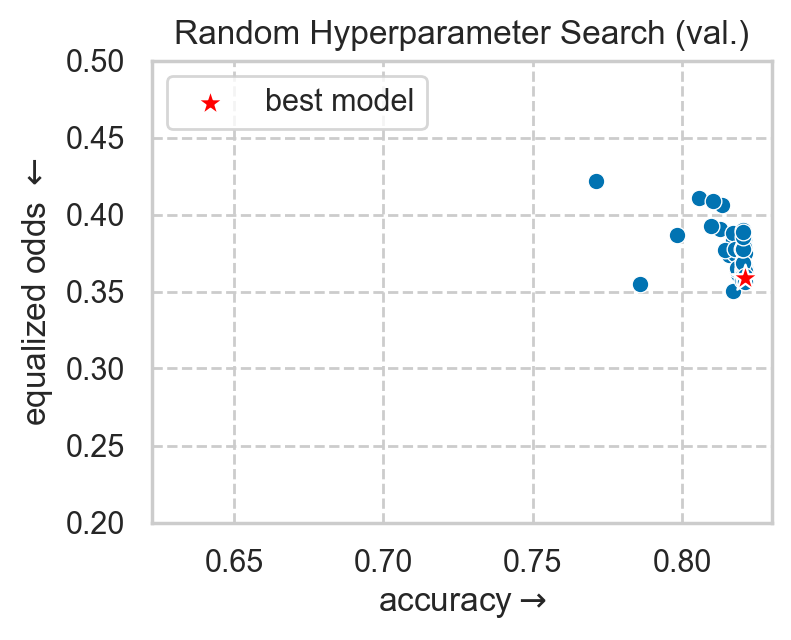

In [10]:
obj_func.plot(x_axis=PERF_METRIC, y_axis=DISP_METRIC, pyplot_show=False)

ax_kwargs = dict(
    xlim=(constant_clf_accuracy["validation"] - 5e-3, 0.83),
    ylim=(0.2, 0.5),
    title="Random Hyperparameter Search (val.)",
    xlabel=PERF_METRIC + r"$\rightarrow$",
    ylabel="equalized odds $\leftarrow$" if DISP_METRIC == "equalized_odds_diff" else DISP_METRIC,
)

plt.legend(loc="upper left")
plt.gca().set(**ax_kwargs)
plt.show()

In [11]:
# Let's retrain the best model
unconstr_clf = obj_func.reconstruct_model(obj_func.best_trial)

Let's map the fairness-accuracy trade-off of the best model using post-processing.
> Uses the `error-parity` package.

In [12]:
from utils.postprocessing import compute_postprocessing_curve

# Data to fit postprocessing adjustment
fit_data = (X_train, y_train, s_train)
# fit_data = (X_val, y_val, s_val)

# Common kwargs for the `compute_postprocessing_curve` call
compute_postproc_kwargs = dict(
    fit_data=fit_data,
    eval_data={
        "validation": (X_val, y_val, s_val),
        "test": (X_test, y_test, s_test),
    },
    fairness_constraint="equalized_odds",
    tolerance_ticks=np.hstack((
        np.arange(0.0, 0.2, 1e-2),
        np.arange(0.2, 1.0, 1e-1),
    )),
    bootstrap=True,
    n_jobs=N_JOBS,
    seed=SEED,
)

postproc_results_df = compute_postprocessing_curve(
    model=unconstr_clf,
    y_fit_pred_scores=unconstr_clf.predict_proba(fit_data[0])[:, -1],
    **compute_postproc_kwargs,
)

  0%|          | 0/28 [00:00<?, ?it/s]

In [13]:
postproc_results_df.head(3)

,tolerance,accuracy_fit-theoretical,equalized_odds_fit-theoretical,accuracy_mean_fit,accuracy_stdev_fit,accuracy_low-percentile_fit,accuracy_high-percentile_fit,accuracy_diff_mean_fit,accuracy_diff_stdev_fit,accuracy_diff_low-percentile_fit,...,tpr_low-percentile_test,tpr_high-percentile_test,tpr_diff_mean_test,tpr_diff_stdev_test,tpr_diff_low-percentile_test,tpr_diff_high-percentile_test,tpr_ratio_mean_test,tpr_ratio_stdev_test,tpr_ratio_low-percentile_test,tpr_ratio_high-percentile_test
0,0.00,0.829011,3.230749e-14,0.829085,0.000394,0.828398,0.829787,0.037262,0.002332,0.033104,...,0.717685,0.722738,0.058394,0.009576,0.038977,0.079141,0.919324,0.013201,0.890726,0.946140
1,0.01,0.835858,1.000000e-02,0.835860,0.000381,0.835180,0.836559,0.023577,0.002105,0.019607,...,0.736739,0.741329,0.064292,0.009501,0.046231,0.083578,0.913451,0.012776,0.887618,0.937779
2,0.02,0.836722,2.000000e-02,0.836724,0.000384,0.836029,0.837436,0.020887,0.001581,0.018254,...,0.739123,0.743532,0.074992,0.009513,0.056045,0.094622,0.899518,0.012707,0.873168,0.924864


### Plot post-processing adjustment frontier

In [14]:
# SHOW_RESULTS_ON = "validation"
SHOW_RESULTS_ON = "test"

hpt_results = obj_func.get_results(SHOW_RESULTS_ON)
best_trial_results = hpt_results.loc[obj_func.best_trial.id]

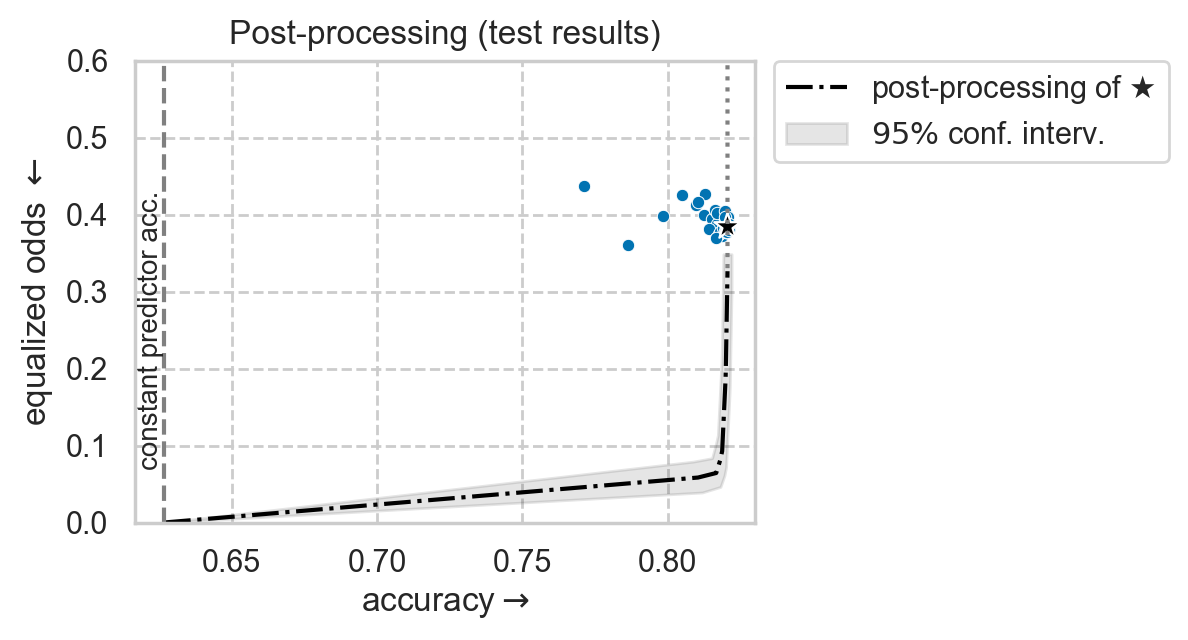

In [15]:
from utils.plotting import plot_postprocessing_frontier

# Plot all unconstrained models
sns.scatterplot(
    data=hpt_results.drop(index=obj_func.best_trial.id),
    x=PERF_METRIC,
    y=DISP_METRIC,
    s=20,
)

# Plot best unconstrained model
sns.scatterplot(
    x=[best_trial_results[PERF_METRIC]],
    y=[best_trial_results[DISP_METRIC]],
    color="black",
    marker="*",
    s=100,
)

# Plot postprocessing of unconstrained model
plot_postprocessing_frontier(
    postproc_results_df,
    perf_metric=PERF_METRIC,
    disp_metric=DISP_METRIC,
    show_data_type=SHOW_RESULTS_ON,
    model_name=r"$\bigstar$",
    constant_clf_accuracy=constant_clf_accuracy[SHOW_RESULTS_ON],
)

# Vertical line with minimum "useful" accuracy on this data
curr_const_clf_acc = constant_clf_accuracy[SHOW_RESULTS_ON]
plt.axvline(
    x=curr_const_clf_acc,
    ls="--",
    color="grey",
)
plt.gca().annotate(
    "constant predictor acc.",
    xy=(curr_const_clf_acc, ax_kwargs["ylim"][1] / 2),
    zorder=10,
    rotation=90,
    horizontalalignment="right",
    verticalalignment="center",
    fontsize="small",
    
)

# Title and legend
ax_kwargs["title"] = f"Post-processing ({SHOW_RESULTS_ON} results)"
ax_kwargs["xlim"] = (curr_const_clf_acc - 1e-2, 0.83)
ax_kwargs["ylim"] = (0, 0.6)

plt.legend(
    loc="upper left",
    bbox_to_anchor=(1.03, 1),
    borderaxespad=0)

plt.gca().set(**ax_kwargs)
save_current_fig(f"postprocessing-unconstr.{SHOW_RESULTS_ON}")

plt.show()

### Let's train another type of fairness-aware model
> _in-processing_ models introduce fairness criteria during training

In [16]:
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds
from lightgbm import LGBMClassifier

inproc_clf = ExponentiatedGradient(
    estimator=unconstr_clf,
    constraints=EqualizedOdds(),
    max_iter=10,
)

Fit the `ExponentiatedGradient` [Agarwal et al., ICML 2018] in-processing intervention (**note**: may take a few minutes to fit).

In [17]:
%%time
inproc_clf.fit(X_train, y_train, sensitive_features=s_train)

CPU times: user 33min 14s, sys: 59.4 s, total: 34min 13s
Wall time: 33min 5s


ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.EqualizedOdds object at 0x10c387fd0>,
                      estimator=LGBMClassifier(data_sample_strategy='bagging',
                                               enable_bundle=False,
                                               learning_rate=0.08376816471894921,
                                               max_depth=7, n_estimators=490,
                                               n_jobs=1, num_leaves=56,
                                               verbosity=-1),
                      max_iter=10, nu=0.00018679641859630042)

Evaluate in-processing model on test data.

In [18]:
from hpt.evaluation import evaluate_predictions_bootstrap

inproc_test_results = evaluate_predictions_bootstrap(
    y_true=y_test,
    y_pred_scores=inproc_clf.predict(X_test, random_state=SEED).astype(float),
    sensitive_attribute=s_test,
)

print(
    f"In-processing model: \n"
    f">       accuracy = {inproc_test_results['accuracy_mean']:.3}\n"
    f"> equalized odds = {inproc_test_results['equalized_odds_diff_mean']:.3}\n"
)

In-processing model: 
>       accuracy = 0.817
> equalized odds = 0.122



**We can go one step further and post-process this in-processing model :)**

In [19]:
from utils.postprocessing import compute_postprocessing_curve

inproc_postproc_results_df = compute_postprocessing_curve(
    model=inproc_clf,
    y_fit_pred_scores=inproc_clf._pmf_predict(fit_data[0])[:, -1],
    predict_method="_pmf_predict",
    **compute_postproc_kwargs,
)

  0%|          | 0/28 [00:00<?, ?it/s]

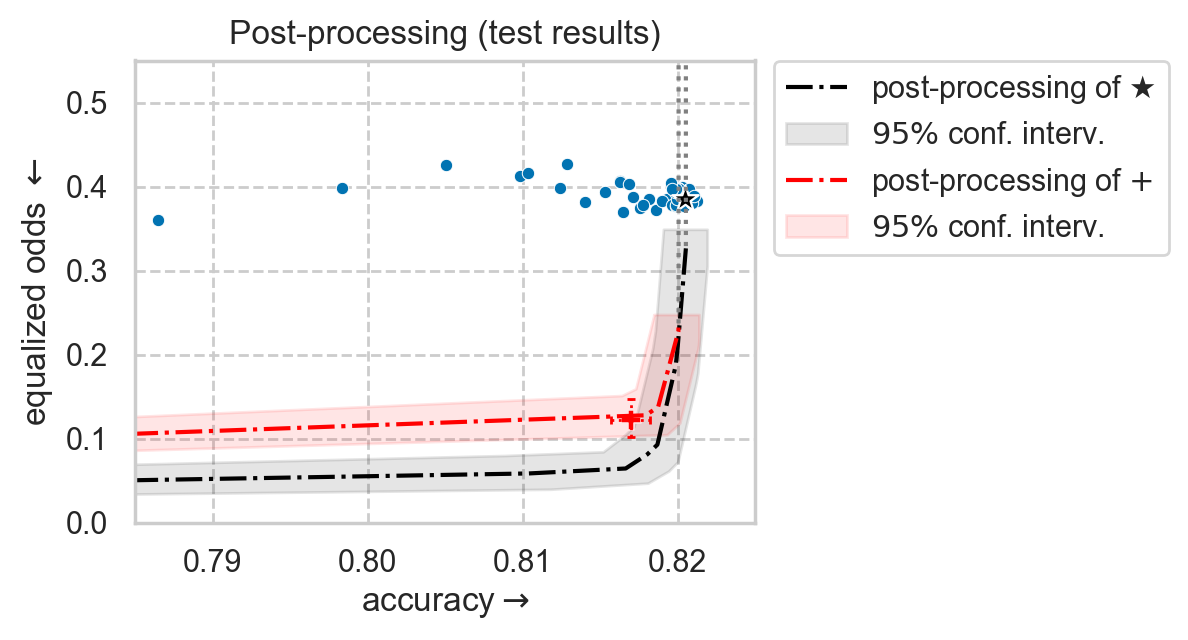

In [22]:
from utils.plotting import plot_postprocessing_frontier

# Plot all unconstrained models
sns.scatterplot(
    data=hpt_results.drop(index=obj_func.best_trial.id),
    x=PERF_METRIC,
    y=DISP_METRIC,
    s=20,
)

# Plot unconstrained model
sns.scatterplot(
    x=[best_trial_results[PERF_METRIC]],
    y=[best_trial_results[DISP_METRIC]],
    color="black",
    marker="*",
    s=100,
)

# Plot postprocessing of unconstrained model
plot_postprocessing_frontier(
    postproc_results_df,
    perf_metric=PERF_METRIC,
    disp_metric=DISP_METRIC,
    show_data_type=SHOW_RESULTS_ON,
    model_name=r"$\bigstar$",
    constant_clf_accuracy=constant_clf_accuracy[SHOW_RESULTS_ON],
)

# Plot inprocessing intervention results
sns.scatterplot(
    x=[inproc_test_results[f"{PERF_METRIC}_mean"]],
    y=[inproc_test_results[f"{DISP_METRIC}_mean"]],
    color="red",
    marker="P",
    s=50,
)

# Plot inprocessing results 95% CIs
plt.plot(
    (inproc_test_results[f"{PERF_METRIC}_low-percentile"], inproc_test_results[f"{PERF_METRIC}_high-percentile"]),
    (inproc_test_results[f"{DISP_METRIC}_mean"], inproc_test_results[f"{DISP_METRIC}_mean"]),
    color='red',
    ls=":",
    marker="|",
    lw=1,
    ms=3,
)

plt.plot(
    (inproc_test_results[f"{PERF_METRIC}_mean"], inproc_test_results[f"{PERF_METRIC}_mean"]),
    (inproc_test_results[f"{DISP_METRIC}_low-percentile"], inproc_test_results[f"{DISP_METRIC}_high-percentile"]),
    color='red',
    ls=":",
    marker="_",
    lw=1,
    ms=3,
)

# Plot postprocessing of inprocessing model
plot_postprocessing_frontier(
    inproc_postproc_results_df,
    perf_metric=PERF_METRIC,
    disp_metric=DISP_METRIC,
    show_data_type=SHOW_RESULTS_ON,
    # model_name=r"$\blacksquare$",
    model_name=r"$+$",
    constant_clf_accuracy=constant_clf_accuracy[SHOW_RESULTS_ON],
    color="red",
)

# Title and legend
ax_kwargs["title"] = f"Post-processing ({SHOW_RESULTS_ON} results)"
ax_kwargs["xlim"] = (0.785, 0.825)
ax_kwargs["ylim"] = (0, 0.55)

plt.legend(
    loc="upper left",
    bbox_to_anchor=(1.03, 1),
    borderaxespad=0)

plt.gca().set(**ax_kwargs)
save_current_fig(f"postprocessing-and-inprocessing.{SHOW_RESULTS_ON}")

plt.show()